In [20]:
import pandas as pd
import seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from rapidfuzz import process, fuzz

import re

# Import tools, unreasonably hard on windows due to no symlink support
import sys, os
sys.path.append(os.path.abspath(os.path.join('..', '..', )))
from tools.pdtools import bootstrap_ci

In [101]:
df_breach_arti  = pd.read_csv("../../data/article_company_breach/left_joined_articles_company_breaches_no_duplicates.csv",)
df_company      = pd.read_csv("../../data/distribution_differences/articles_about_companies_joined_companies_no_duplicates.csv")
df_breach     = pd.read_csv("../../data/article_company_breach/left_joined_breaches_companies_no_duplicates.csv")
#df_company[df_company['BreachMentioned'] != "False"].drop(['Date', 'Publication', 'Headline', 'URL', 'BreachMentioned', 'CompanyMentioned'], axis=1).drop_duplicates(subset=['organisation', 'breach_date', 'sector'], keep='first')

In [116]:
# Bootstrap CI for the number of articles per industry
def calc_distrib(subdf):
    return subdf["industry"].value_counts() / len(subdf)

base_rates   = bootstrap_ci(df_company, calc_distrib, frac=1, n=1000)
breach_rates = bootstrap_ci(df_breach, calc_distrib, frac=1, n=1000)

In [117]:
# Convert each to a single number estimate
df = pd.merge(base_rates, breach_rates, left_index=True, right_index=True, suffixes=("_base", "_breach"))

df["rate_base"]   = df["count_base"].apply(lambda x: np.mean(x))
df["rate_breach"] = df["count_breach"].apply(lambda x: np.mean(x))

df["error_base"]   = df["count_base"].apply(lambda x: x[1]-x[0])
df["error_breach"] = df["count_breach"].apply(lambda x: x[1]-x[0])

In [118]:
# Select only the top 15 industries, by difference
N = 15

# Calculate the max difference between any two proportions
def ci_diff(ci_x, ci_y):
    if ci_y[1] < ci_x[0]:
        return ci_x[0] - ci_y[1]
    elif ci_x[1] < ci_y[0]:
        return ci_y[0] - ci_x[1]
    else:
        # Ideally, return 0, but so that some of the options still mean something, return a small value
        return 1e-10 * np.mean([ci_x[1] - ci_y[0], ci_y[1] - ci_x[0]])

df["max_diff"] = df.apply(lambda x: ci_diff(x["count_base"], x["count_breach"]), axis=1)
selected_industries = df.sort_values("max_diff", ascending=False).head(N).index

In [119]:
df_viz = pd.melt(
    df.loc[selected_industries].reset_index(),
    id_vars=["industry"],
    value_vars=["rate_base", "rate_breach"],
    var_name="Rate Type",
    value_name="Rate",
)

# pseudojoin on error bars
df_viz["Error"] = df_viz.apply(lambda x: df.loc[x["industry"]]["error_base"] if x["Rate Type"] == "rate_base" else df.loc[x["industry"]]["error_breach"], axis=1)

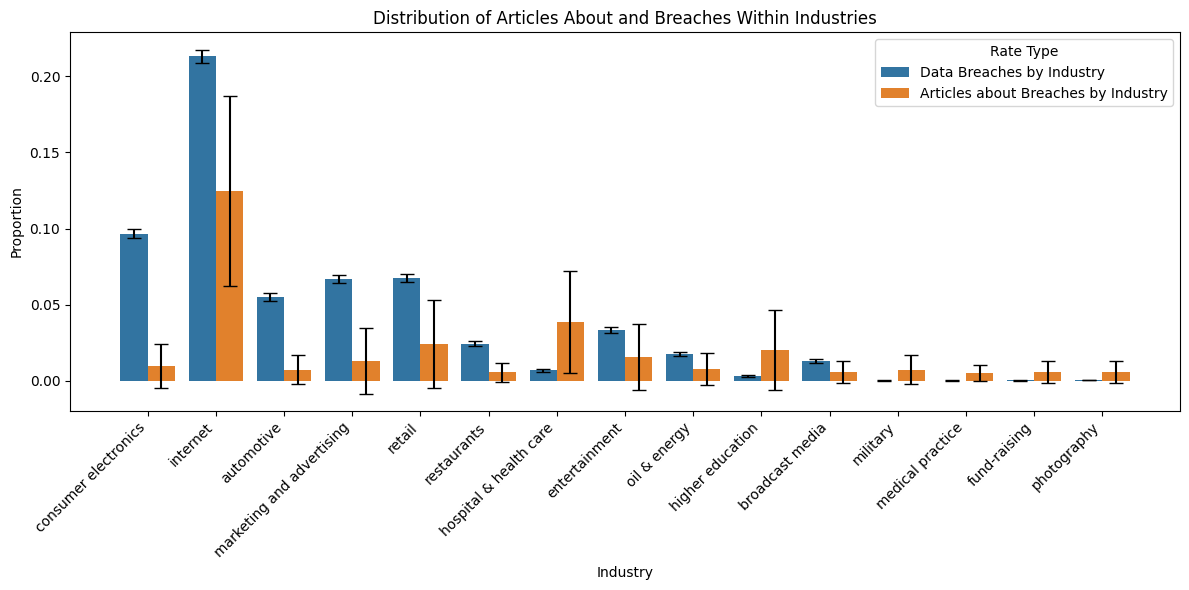

In [120]:
plt.figure(figsize=(12, 6))
barplot = sns.barplot(
    data=df_viz,
    x="industry",
    y="Rate",
    hue="Rate Type",
    #palette="muted",
    errorbar=None
)

# Add error bars manually
for i, bar in enumerate(list(barplot.patches)[:-2]):
    # Calculate position
    group_index = i // 2  # Each group (Industry) has 2 bars
    error = df_viz["Error"].iloc[i]
    plt.errorbar(
        bar.get_x() + bar.get_width() / 2,  # Center of the bar
        bar.get_height(),  # Top of the bar
        yerr=error,  # Error value
        fmt="none",  # No marker
        c="black",  # Color of error bars
        capsize=5  # Cap size
    )
    
plt.title("Distribution of Articles About and Breaches Within Industries")
plt.xlabel("Industry")
plt.ylabel("Proportion")
plt.legend(title="Rate Type", labels=["Data Breaches by Industry", "Articles about Breaches by Industry"])
plt.xticks(rotation=45, ha="right")
plt.tight_layout()